# Lista prática II

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Regressão linear

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

Definição das classes ```LinearRegressionSGD``` e ```LinearRegressionOLS```:

In [27]:
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from tqdm import tqdm


class LinearRegression(ABC):
    def __init__(self, standardize=True):
        self.standardize = standardize
        self.scaler_X_ = None
        self.scaler_y_ = None
        self.coef_ = None
        self.intercept_ = None

    @abstractmethod
    def fit(self, X, y):
        """Subclasses must implement fit."""
        pass

    def predict(self, X):
        X = np.array(X)
        if self.standardize:
            X = self.scaler_X_.transform(X)
        y_pred = self.intercept_ + X @ self.coef_
        if self.standardize:
            y_pred = self.scaler_y_.inverse_transform(
                y_pred.reshape(-1, 1)
            ).flatten()
        return y_pred

    def score(self, X, y):
        """Returns the MSE."""
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)


class LinearRegressionOLS(LinearRegression):
    def __init__(self, standardize=True):
        super().__init__(standardize=standardize)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        if self.standardize:
            self.scaler_X_ = StandardScaler()
            self.scaler_y_ = StandardScaler()
            X = self.scaler_X_.fit_transform(X)
            y = self.scaler_y_.fit_transform(y.reshape(-1, 1)).flatten()

        X_bias = np.c_[np.ones(X.shape[0]), X]
        theta = np.linalg.inv(X_bias.T @ X_bias) @ (X_bias.T @ y)

        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self


class LinearRegressionSGD(LinearRegression):
    def __init__(
        self,
        learning_rate=0.01,
        batch_size=32,
        epsilon=1e-6,
        max_epochs=1000,
        standardize=True,
        random_state=0,
    ):
        super().__init__(standardize=standardize)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.loss_history_train = None
        self.loss_history_val = None

    def _get_loss(self, X, y, theta):
        intercept = theta[0]
        coef = theta[1:]
        preds = intercept + X @ coef
        return np.mean((preds - y) ** 2)

    def fit(self, X, y, X_val, y_val):
        X = np.array(X)
        y = np.array(y)
        X_val = np.array(X_val)
        y_val = np.array(y_val)

        if self.standardize:
            self.scaler_X_ = StandardScaler()
            self.scaler_y_ = StandardScaler()
            X = self.scaler_X_.fit_transform(X)
            y = self.scaler_y_.fit_transform(y.reshape(-1, 1)).flatten()
            X_val = self.scaler_X_.transform(X_val)
            y_val = self.scaler_y_.transform(y_val.reshape(-1, 1)).flatten()

        X_bias = np.c_[np.ones(X.shape[0]), X]
        n_samples, n_features = X_bias.shape

        rng = np.random.default_rng(self.random_state)
        theta = rng.normal(loc=0.0, scale=100.0, size=n_features)
        
        self.loss_history_train = []
        self.loss_history_val = []

        for i in tqdm(range(self.max_epochs)):
            epoch = i + 1
            idx = rng.permutation(n_samples)
            X_shuff, y_shuff = X_bias[idx], y[idx]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuff[start: end]
                y_batch = y_shuff[start: end]

                grad = (
                    (2 / X_batch.shape[0])
                    * X_batch.T
                    @ (X_batch @ theta - y_batch)
                )
                new_theta = theta - self.learning_rate * grad

                if np.linalg.norm(new_theta - theta) < self.epsilon:
                    theta = new_theta
                    self.intercept_ = theta[0]
                    self.coef_ = theta[1:]
                    print(f"Converged after {epoch} epochs.")
                    return self

                theta = new_theta

            self.loss_history_train.append(self._get_loss(X, y, theta))
            self.loss_history_val.append(self._get_loss(X_val, y_val, theta))

        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self

Diferentes tamanhos de minibatch:

Batch size: 2


  0%|          | 10/500000 [00:00<3:04:19, 45.21it/s]

Converged after 11 epochs.
Training time: 0.225126 seconds
Validation MSE (SGD): 4.792627752462148
Test MSE (SGD): 5.1437341549632025


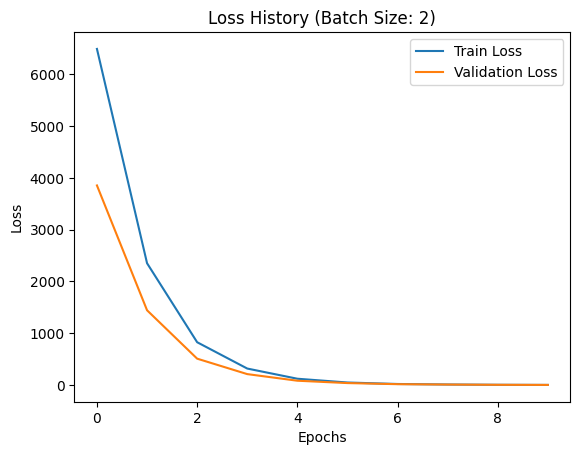

Batch size: 4


  0%|          | 37/500000 [00:00<1:27:07, 95.64it/s]


Converged after 38 epochs.
Training time: 0.389109 seconds
Validation MSE (SGD): 0.6034194639454109
Test MSE (SGD): 0.5905395289623138


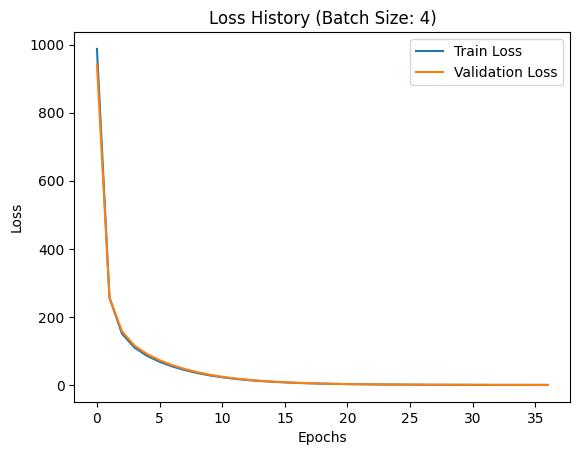

Batch size: 8


  0%|          | 677/500000 [00:03<43:29, 191.37it/s]

Converged after 678 epochs.
Training time: 3.540147 seconds
Validation MSE (SGD): 0.5357006818415097
Test MSE (SGD): 0.5408260949826141


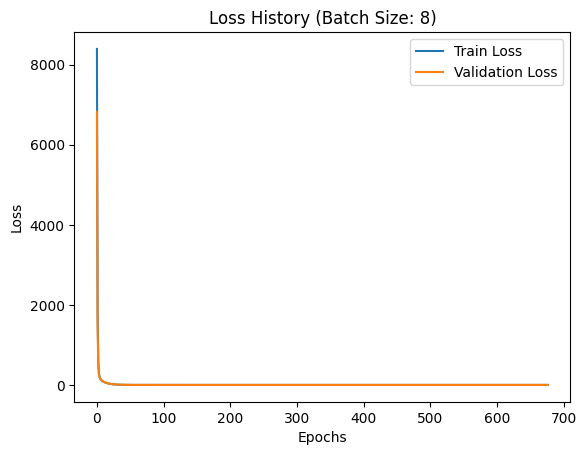

Batch size: 16


  0%|          | 580/500000 [00:01<23:50, 349.08it/s]

Converged after 581 epochs.
Training time: 1.663445 seconds
Validation MSE (SGD): 0.5354100411360849
Test MSE (SGD): 0.5427020152964562


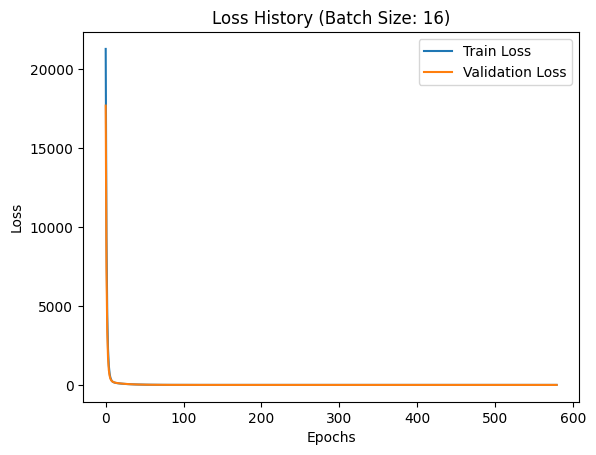

Batch size: 32


  2%|▏         | 11855/500000 [00:18<13:01, 624.86it/s]

Converged after 11856 epochs.
Training time: 18.974330 seconds
Validation MSE (SGD): 0.5355330630186489
Test MSE (SGD): 0.5424743019053764


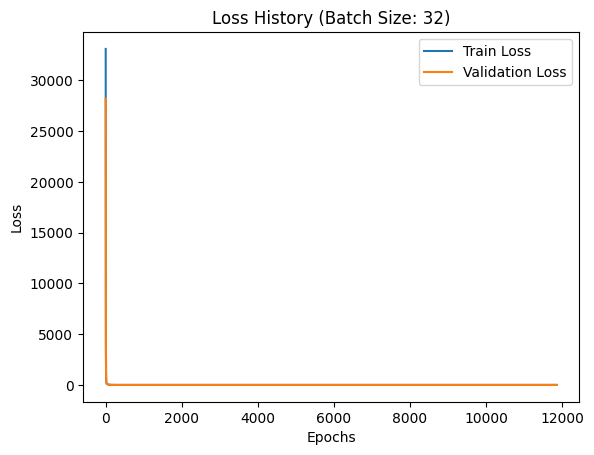

Batch size: 64


  1%|          | 4624/500000 [00:04<08:04, 1022.23it/s]

Converged after 4625 epochs.
Training time: 4.525487 seconds
Validation MSE (SGD): 0.5356009839387361
Test MSE (SGD): 0.5421470390407385


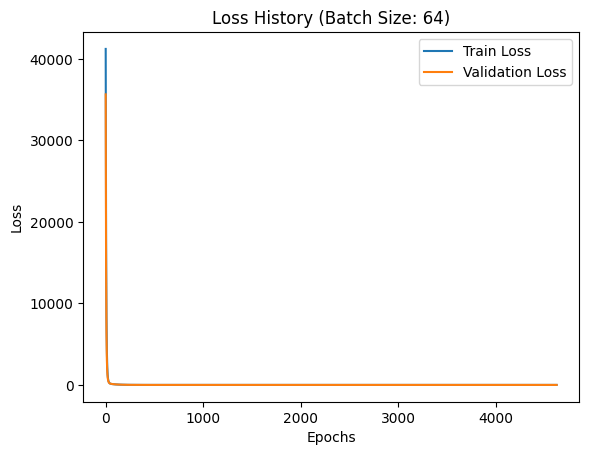

Batch size: 128


  0%|          | 2152/500000 [00:01<06:15, 1326.82it/s]

Converged after 2153 epochs.
Training time: 1.624102 seconds
Validation MSE (SGD): 0.5347670400784308
Test MSE (SGD): 0.5397208564219383


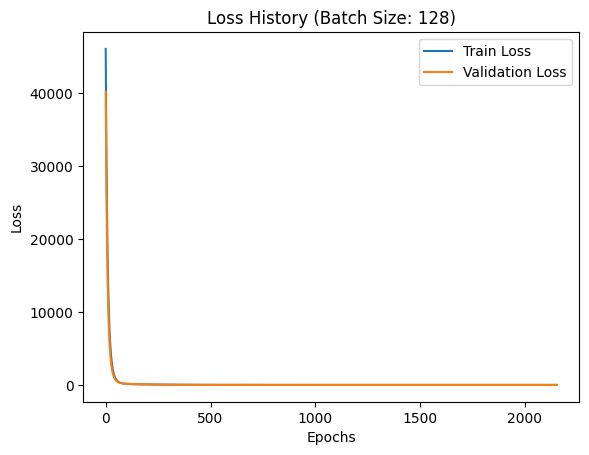

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import time

results = []
for j in range(1, 8):
    batch_size = 2 ** j
    print(f"Batch size: {batch_size}")

    lr = 0.0002
    eplsion = 1e-5
    linear_reg_sgd = LinearRegressionSGD(
        learning_rate=lr,
        batch_size=batch_size,
        epsilon=eplsion,
        max_epochs=500000,
        standardize=True,
        random_state=0,
    )

    start_time = time.time()
    linear_reg_sgd.fit(features_train, labels_train, features_validation, labels_validation)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.6f} seconds")

    val_score = linear_reg_sgd.score(features_validation, labels_validation)
    print(f"Validation MSE (SGD): {val_score}")

    test_score = linear_reg_sgd.score(features_test, labels_test)
    print(f"Test MSE (SGD): {test_score}")

    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'epsilon': eplsion,
        'validation_mse': val_score,
        'test_mse': test_score,
        'training_time': end_time - start_time,
    })

    plt.plot(linear_reg_sgd.loss_history_train, label='Train Loss')
    plt.plot(linear_reg_sgd.loss_history_val, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss History (Batch Size: {batch_size})')
    plt.show()

results_df = pd.DataFrame(results)

In [35]:
results_df

,batch_size,learning_rate,epsilon,validation_mse,test_mse,training_time
0,2,0.0002,0.00001,4.792628,5.143734,0.225126
1,4,0.0002,0.00001,0.603419,0.590540,0.389109
2,8,0.0002,0.00001,0.535701,0.540826,3.540147
3,16,0.0002,0.00001,0.535410,0.542702,1.663445
4,32,0.0002,0.00001,0.535533,0.542474,18.974330
5,64,0.0002,0.00001,0.535601,0.542147,4.525487
6,128,0.0002,0.00001,0.534767,0.539721,1.624102


In [36]:
linear_reg_ols = LinearRegressionOLS(
    standardize=True,
)
linear_reg_ols.fit(features_train, labels_train)
optimal_score_val = linear_reg_ols.score(features_validation, labels_validation)
optimal_score_test = linear_reg_ols.score(features_test, labels_test)

print(f"Valor ótimo do MSE em validação (OLS): {optimal_score_val}")
print(f"Valor ótimo do MSE em teste (OLS): {optimal_score_test}")

Valor ótimo do MSE em validação (OLS): 0.5356253807285287
Valor ótimo do MSE em teste (OLS): 0.54208495407831


A partir do minibatch 8, o MSE da validação e do teste já chegaram próximos dos valores ótimos obtidos com o OLS.

O tempo de treinamento tende a crescer à medida que o tamanho do minibatch aumenta. Porém, isso não ocorre necessariamente, visto que há uma aleatoriedade envolvida na estimativa dos gradientes. Minibatches maiores produzem estimativas de gradiente mais estáveis e precisas, enquanto minibatches menores resultam em estimativas mais ruidosas.

**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [182]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[10.  2.]
 [ 1.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.

In [143]:
class RBFNetwork:
    def __init__(self, n_clusters, gamma=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.centers = None
        self.linear_model = LinearRegressionOLS(standardize=True)

    def _rbf(self, x, c):
        return np.exp(-self.gamma * np.linalg.norm(x - c) ** 2)

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((X.shape[0], self.n_clusters))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = self._rbf(x, c)
        return G

    def fit(self, X, y):
        k_means_model = k_means_factory(self.n_clusters)
        k_means_model.fit(X)
        self.centers = k_means_model.cluster_centers_

        if self.gamma is None:
            d_max = -np.inf
            for i in range(len(self.centers)):
                for j in range(i + 1, len(self.centers)):
                    d_max = max(
                        d_max,
                        np.linalg.norm(self.centers[i] - self.centers[j])
                    )
            self.gamma = 1.0 / (d_max ** 2)

        G = self._calculate_interpolation_matrix(X)

        self.linear_model.fit(G, y)

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        return self.linear_model.predict(G)

    def score(self, X, y):
        G = self._calculate_interpolation_matrix(X)
        return self.linear_model.score(G, y)

Exemplo para um valor específico de ```n_clusters```:

In [144]:
features_train.shape

(11610, 8)

In [203]:
n_clusters = 30

rbf_network = RBFNetwork(n_clusters=n_clusters)
rbf_network.fit(features_train, labels_train)

score_val = rbf_network.score(features_validation, labels_validation)
print(f"Validation MSE (RBF Network): {score_val}")

Validation MSE (RBF Network): 0.7554830208979101


Tuning:

In [204]:
results = []
for n_clusters in tqdm(range(2, 201, 2)):
    rbf_network = RBFNetwork(n_clusters=n_clusters)
    rbf_network.fit(features_train, labels_train)

    score_val = rbf_network.score(features_validation, labels_validation)
    # print(f"Validation MSE (RBF Network with {n_clusters} clusters): {score_val}")
    results.append({
        'n_clusters': n_clusters,
        'validation_mse': score_val
    })
results_df = pd.DataFrame(results)

100%|██████████| 100/100 [03:55<00:00,  2.35s/it]


In [205]:
results_df.sort_values(by='validation_mse')

,n_clusters,validation_mse
98,198,0.563020
38,78,0.571872
64,130,0.607274
61,124,0.613436
60,122,0.629743
...,...,...
25,52,50.443578
75,152,60.666572
27,56,102.281759
73,148,320.885032


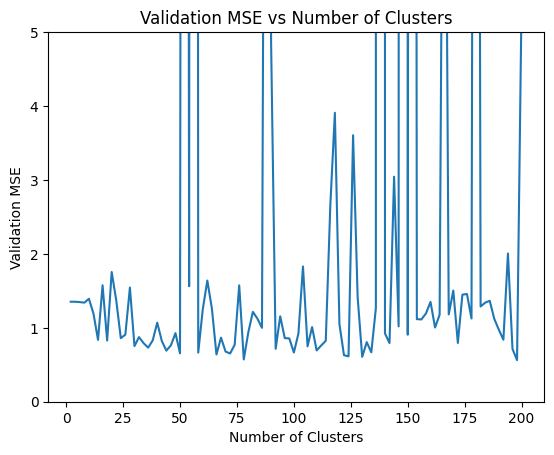

In [218]:
results_df.set_index('n_clusters')['validation_mse'].plot()
plt.ylim(0, 5)
plt.title('Validation MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Validation MSE')
plt.show()

In [206]:
best_n_clusters = results_df.loc[results_df['validation_mse'].idxmin(), 'n_clusters']
print(f"Best n_clusters: {best_n_clusters}")

Best n_clusters: 198


In [208]:
best_rbf_network = RBFNetwork(n_clusters=best_n_clusters)
best_rbf_network.fit(features_train, labels_train)

best_score_test = best_rbf_network.score(features_test, labels_test)
print(f"Test MSE (Best RBF Network with {best_n_clusters} clusters): {best_score_test}")

Test MSE (Best RBF Network with 198 clusters): 0.609552984792411


Observando o gráfico, não é nítido um padrão claro de melhoria do erro de validação com o aumento do número de clusters.

Escolhendo o modelo com o menor erro em validação (0.5630), temos 198 clusters. O erro em teste para este modelo é 0.6096, o que pode indicar um leve overfitting.

Apesar de ser um modelo mais complexo, a Rede RBF não superou o modelo linear simples, que obteve um erro em validação de 0.5356 e em teste de 0.5421.